In [1]:
# !apt-get update && apt-get install libsm6 libxext6 -y -qq
# !apt-get install libgl1-mesa-glx graphviz -y -qq
# !pip install -r requirements.txt -q
# import os
# os._exit(0)
# # # !apt-get install unrar

# IMPORT PACKAGES

In [4]:
import os
import shutil
import PIL
import numpy as np
import cv2
import zipfile
from PIL import Image
import tensorflow as tf
import pandas as pd
import pathlib
import natsort
import sys
import math
import random
import albumentations as A

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
%load_ext autotime

print(tf.__version__)
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
2.15.0
time: 901 µs (started: 2025-04-28 09:01:30 +00:00)


In [5]:
EPOCHS = 500
BATCH = 2
ETA = 1e-3
WEIGHT_DECAY = 6e-8
HEIGHT = 384
WIDTH = 768
IMAGE_SHAPE = (HEIGHT, WIDTH, 1)
model_path = 'models'
plot_path = 'chart'

time: 331 µs (started: 2025-04-28 09:01:30 +00:00)


In [6]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Enable GPU memory growth (optional)
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    # Set mixed precision policy
    # policy = tf.keras.mixed_precision.Policy('mixed_float16')
    # tf.keras.mixed_precision.set_global_policy(policy)

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("TensorFlow GPU device: ", tf.test.gpu_device_name())
print("All devices: ", tf.config.list_physical_devices())

Num GPUs Available:  1
TensorFlow GPU device:  /device:GPU:0
All devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
time: 2.37 ms (started: 2025-04-28 09:01:30 +00:00)


2025-04-28 09:01:30.240971: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-28 09:01:30.241452: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-28 09:01:30.241555: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

# READ DATASET (IMAGES, MASKS)

In [7]:
class readDataset:
    def __init__(self, imagesPathes, masksPathes):
        self.imagesPathes = imagesPathes
        self.masksPathes = masksPathes
        self.images = None
        self.masks = None
        self.val_images = None
        self.val_masks = None
        self.test_images = None
        self.test_masks = None

    def readPathes(self,):
        self.images = natsort.natsorted(list(pathlib.Path(self.imagesPathes).glob('*.*')))
        self.masks = natsort.natsorted(list(pathlib.Path(self.masksPathes).glob('*.*')))
        # Clean up .ipynb_checkpoints
        for directory in [self.imagesPathes, self.masksPathes]:
            try:
                shutil.rmtree(os.path.join(directory, ".ipynb_checkpoints"))
                print(f".ipynb_checkpoints directory deleted successfully from {directory}.")
            except Exception:
                pass

    def readImages(self, data, typeData, height, width):
        images = []
        height = height
        width =  width
        for img in data:
            img_name = img.name
            img = cv2.imread(str(img), 0)
            img = cv2.resize(img, (width, height), interpolation=cv2.INTER_AREA)
            if typeData == 'm':
                img = np.where(img > 0, 1, 0)
            img = np.expand_dims(img, axis=-1)
            images.append(img)
        print("(INFO..) Read Image Done")
        return np.array(images)

    def normalizeImages(self, images):
        normalized_images = []
        clahe = cv2.createCLAHE(clipLimit=1, tileGridSize=(3,3))
        for img in images:
            img = img.astype(np.uint8)
            img = clahe.apply(img)
            img = np.expand_dims(img, axis=-1)
            img = img / 255.
            normalized_images.append(img)
        print("(INFO..) Normalization Image Done")
        return np.array(normalized_images)

    def dataAugmentation(self, images, masks, n_augments=4):
        augmentation = A.ReplayCompose([
            A.HorizontalFlip(p=0.5),
            # Vertical Translation
            A.ShiftScaleRotate(
                shift_limit_x=(-0.05, 0.05),
                shift_limit_y=(-0.1, 0.05),
                scale_limit=(-0.05, 0.05), 
                rotate_limit=0,
                interpolation=cv2.INTER_AREA,
                mask_interpolation=cv2.INTER_AREA,
                border_mode=cv2.BORDER_CONSTANT,
                p=0.5,
            ),
            A.RandomGamma(p=0.5),
            A.RandomBrightnessContrast(brightness_limit=(-0.25, 0.4),
                                       contrast_limit=(-0.25, 0.35),
                                       p=0.5),
            A.ElasticTransform(alpha=10, 
                               sigma=10, 
                               interpolation=cv2.INTER_AREA,
                               mask_interpolation=cv2.INTER_AREA,
                               p=0.2)
        ], bbox_params=None)

        if len(images) != len(masks):
            raise ValueError("Number of images and masks must be the same.")

        augmented_images = []
        augmented_masks = []
        for image, mask in zip(images, masks):
            # Original image and mask
            augmented_images.append(image)
            augmented_masks.append(mask)

            image = image.astype(np.uint8)
            mask = mask.astype(np.uint8)

            # Perform augmentations
            # Generate n_augments augmented versions per image
            for _ in range(n_augments):                
                # Handle single-channel images
                if len(image.shape) == 2:
                    image = np.expand_dims(image, axis=-1)
                if len(mask.shape) == 2:
                    mask = np.expand_dims(mask, axis=-1)
                # Apply augmentation
                augmented = augmentation(image=image, mask=mask)
                augmented_images.append(augmented['image'])
                augmented_masks.append(augmented['mask'])

        print(f"(INFO..) Augmentation Image Done")
        print(f"(INFO..) Before augmentation: {len(images)} images")
        print(f"(INFO..) After augmentation: {len(augmented_images)} images")

        return np.array(augmented_images), np.array(augmented_masks)
        
    
    def splitDataset(self, images, masks, val_size=20, test_size=10, random_state=42, n_augments=4):
        data = list(zip(images, masks))
        train_data, test_data = train_test_split(data, test_size=(val_size + test_size), random_state=random_state)
        val_data, test_data = train_test_split(test_data, test_size=(test_size / (val_size + test_size)), random_state=random_state)

        train_images, train_masks = zip(*train_data)
        val_images, val_masks = zip(*val_data)
        test_images, test_masks = zip(*test_data)

        # Augment train data
        train_images_aug, train_masks_aug = self.dataAugmentation(np.array(train_images), np.array(train_masks), n_augments)
        
        print("(INFO..) Splitting and Saving Data Done")
        return (np.array(train_images_aug), np.array(train_masks_aug), 
                np.array(val_images), np.array(val_masks), 
                np.array(test_images), np.array(test_masks))


images_path = 'dataset/images'
masks_path = 'dataset/masks'
    
dataset = readDataset(images_path, masks_path)
dataset.readPathes()
    
# Read images
images = dataset.readImages(dataset.images, 'i', HEIGHT, WIDTH)
masks = dataset.readImages(dataset.masks, 'm', HEIGHT, WIDTH)

# Split and augment dataset
trainImages, trainMasks, validImages, validMasks, testImages, testMasks = dataset.splitDataset(images, masks, n_augments=4)

trainImages = dataset.normalizeImages(trainImages)
validImages = dataset.normalizeImages(validImages)
testImages = dataset.normalizeImages(testImages)

(INFO..) Read Image Done
(INFO..) Read Image Done
(INFO..) Augmentation Image Done
(INFO..) Before augmentation: 163 images
(INFO..) After augmentation: 815 images
(INFO..) Splitting and Saving Data Done
(INFO..) Normalization Image Done
(INFO..) Normalization Image Done
(INFO..) Normalization Image Done
time: 19.5 s (started: 2025-04-28 09:01:30 +00:00)


In [8]:
print(f"Data Train: {trainImages.shape}, {trainMasks.shape}")
print(f"Data Validation: {validImages.shape}, {validMasks.shape}")
print(f"Data Test: {testImages.shape}, {testMasks.shape}")

Data Train: (815, 384, 768, 1), (815, 384, 768, 1)
Data Validation: (20, 384, 768, 1), (20, 384, 768, 1)
Data Test: (10, 384, 768, 1), (10, 384, 768, 1)
time: 488 µs (started: 2025-04-28 09:01:50 +00:00)


In [9]:
np.unique(trainMasks), np.min(trainMasks), np.max(trainMasks),  np.min(trainImages), np.max(trainImages)

(array([0, 1]), 0, 1, 0.0, 1.0)

time: 5.84 s (started: 2025-04-28 09:01:50 +00:00)


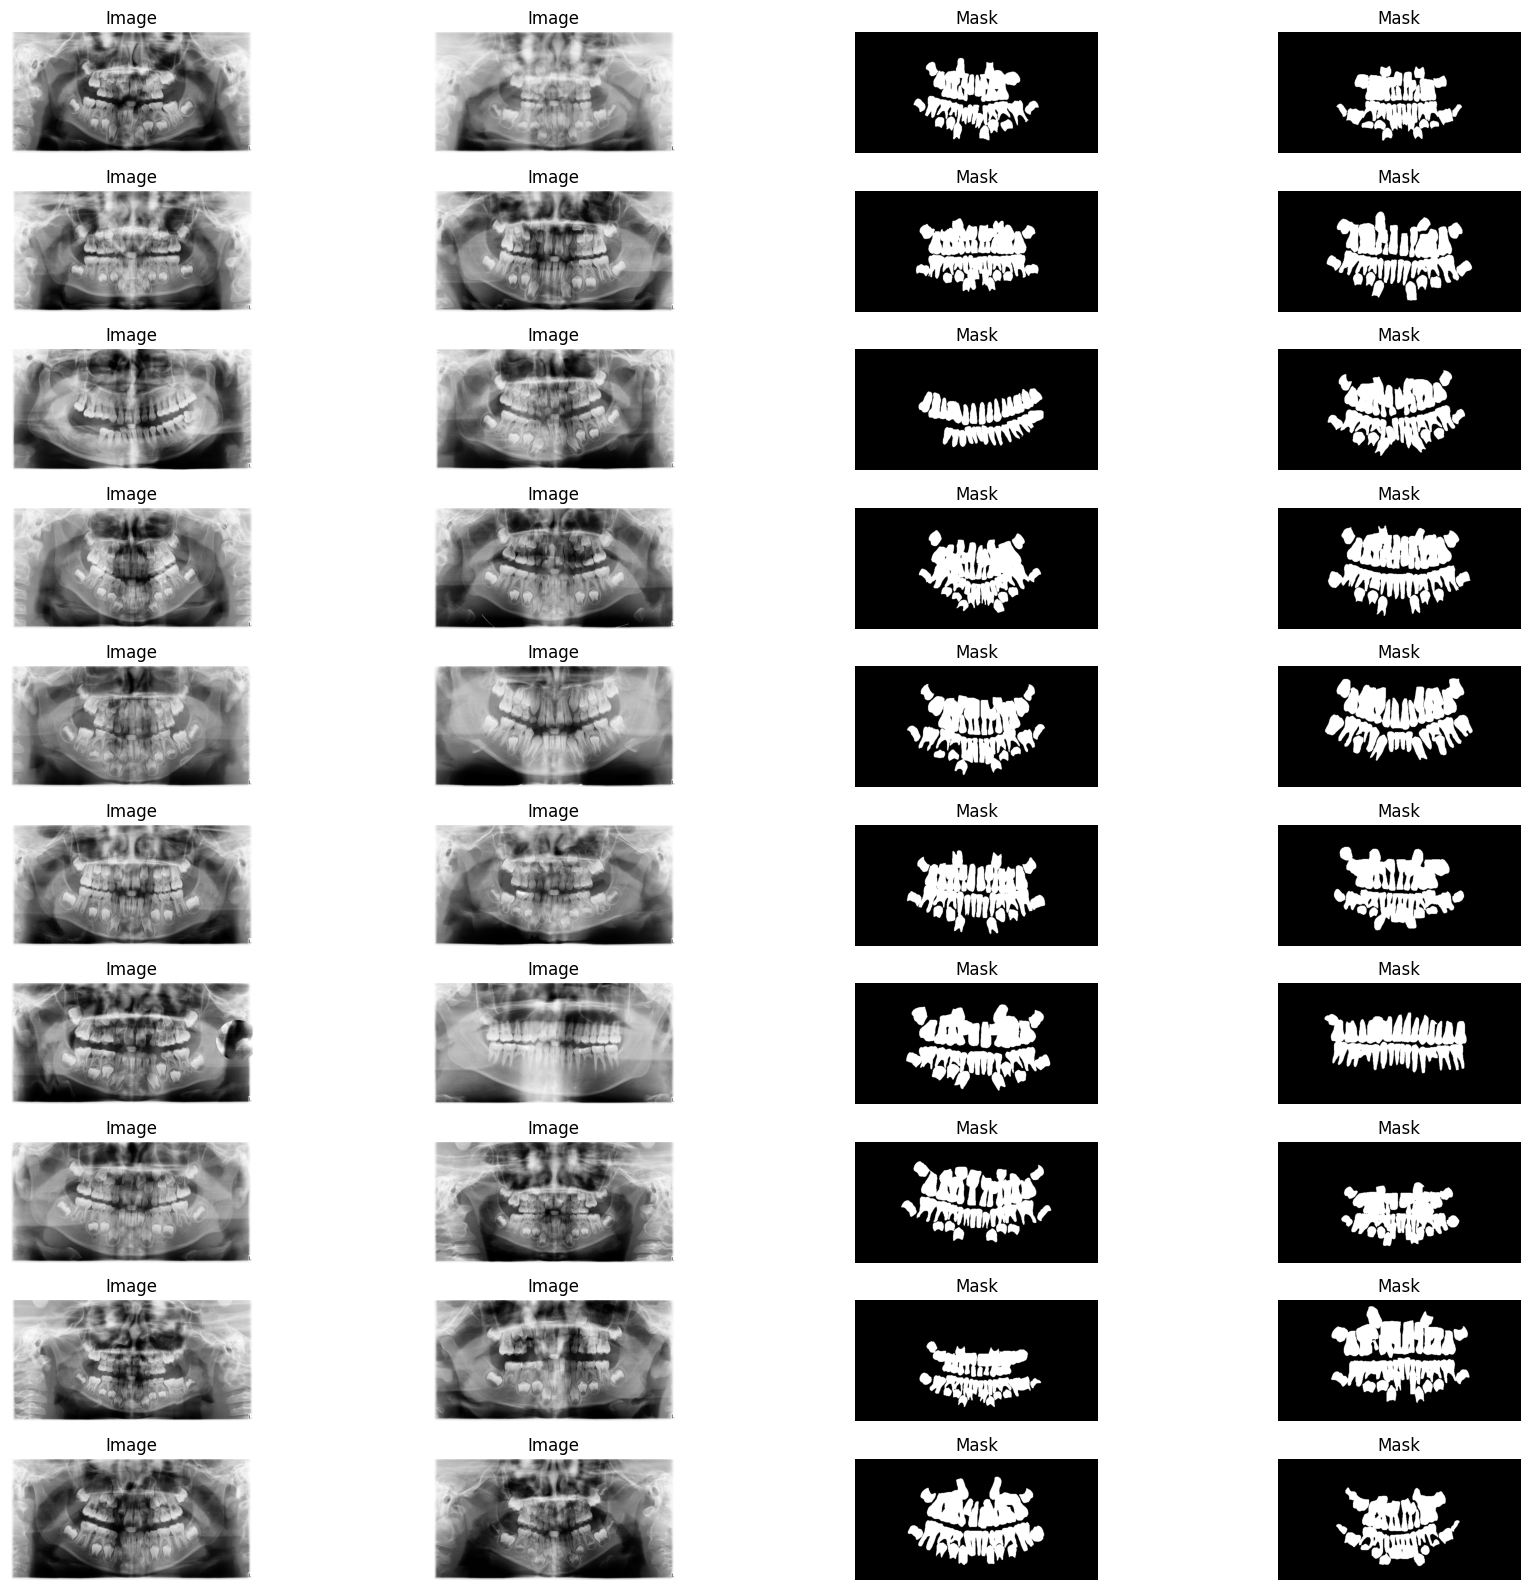

time: 2.23 s (started: 2025-04-28 09:01:56 +00:00)


In [10]:
plt.figure(figsize=(18, 16))
gs = gridspec.GridSpec(20 // 2, 4, width_ratios=[1, 1, 1, 1])
for i in range(20):
    ax0 = plt.subplot(gs[i // 2, i % 2])
    ax1 = plt.subplot(gs[i // 2, i % 2 + 2])
    ax0.imshow(validImages[i], cmap='gray', aspect='auto')
    ax1.imshow(validMasks[i], cmap='gray', aspect='auto')
    ax0.set_title('Image')
    ax1.set_title('Mask')
    ax0.axis('off')
    ax1.axis('off')
    ax0.set_aspect('equal')
    ax1.set_aspect('equal')
plt.tight_layout()
plt.show()

# Define Dice Loss

In [11]:
def dice_score(y_true, y_pred, threshold=0.5):
    smooth = 1.
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), dtype=tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred >= threshold, [-1]), dtype=tf.float32)
    intersection = y_true_f * y_pred_f
    score = (2. * tf.reduce_sum(intersection) + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1. - dice_score(y_true, y_pred)
    return tf.cast(loss, dtype=tf.float32)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return tf.cast(bce, dtype=tf.float32) + dice

def bfce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryFocalCrossentropy()(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return tf.cast(bce, dtype=tf.float32) + dice

def binaryIoU_loss(y_true, y_pred):
    IoU =  tf.keras.metrics.BinaryIoU()(y_true, y_pred)
    return 1 - IoU

time: 927 µs (started: 2025-04-28 09:01:58 +00:00)


# Proposing a generative neural network architecture

In [12]:
def convolution(input, filter, padding, strides, kernel, activation, conv_type, name_prefix=''):
    initializer = tf.random_normal_initializer(0., 0.02)
    x = input
    x = layers.Conv2D(filter, kernel_size=kernel, padding=padding, strides=strides, 
                      kernel_initializer=initializer, use_bias=False, name=f'{name_prefix}_conv1')(x)
    x = layers.GroupNormalization(groups=filter, name=f'{name_prefix}_gn1')(x)
    
    if conv_type == 'decoder':
        x = layers.Activation(activation, name=f'{name_prefix}_activation1')(x)
        x = layers.Conv2D(filter*2, kernel_size=kernel, padding=padding, strides=strides, 
                          kernel_initializer=initializer, use_bias=False, name=f'{name_prefix}_conv2')(x)
        x = layers.GroupNormalization(groups=filter*2, name=f'{name_prefix}_gn2')(x)
        x = layers.Activation(activation, name=f'{name_prefix}_activation2')(x)
        x = layers.Conv2D(filter, kernel_size=kernel, padding=padding, strides=strides, 
                          kernel_initializer=initializer, use_bias=False, name=f'{name_prefix}_conv3')(x)
        x = layers.GroupNormalization(groups=filter, name=f'{name_prefix}_gn3')(x)
    
    x = layers.average([x, layers.Conv2D(filter, kernel_size=1, padding='same', strides=1, kernel_initializer=initializer, name=f'{name_prefix}_conv4')(input)], name=f'{name_prefix}_residual_connection')
    x = layers.Activation(activation, name=f'{name_prefix}_rescon_activation')(x)
    return x

time: 958 µs (started: 2025-04-28 09:01:58 +00:00)


In [13]:
def encoder(input, filter, padding, strides, kernel, activation, name_prefix):
    x = input
    x = convolution(x, filter, padding, strides, kernel, activation, 'encoder', name_prefix=name_prefix)
    downsample = layers.AveragePooling2D(pool_size=(2, 2), name=f'{name_prefix}_pool')(x)
    return downsample, x

time: 852 µs (started: 2025-04-28 09:01:58 +00:00)


In [14]:
def decoder(input, filter, skip, padding, strides, kernel, activation, name_prefix, dropout=False):
    x = input
    initializer = tf.random_normal_initializer(0., 0.02)
    x = layers.Conv2DTranspose(filter, padding = padding, kernel_size = kernel,
                               activation=activation, strides = 2, kernel_initializer=initializer,
                               use_bias=False, name=f'{name_prefix}_transpose')(x)
    
    if dropout:
        x = layers.Dropout(0.5, name=f'{name_prefix}_dropout')(x)
    x = layers.average([x, skip], name=f'{name_prefix}_skip_connection')
    x = convolution(x, filter, padding, strides, kernel, activation, 'decoder', name_prefix=name_prefix)
    return x

time: 567 µs (started: 2025-04-28 09:01:58 +00:00)


In [15]:
def bottleneck(input, filters_bottleneck, strides, kernel, activation, depth=6, mode='cascade', name_prefix=''):
    dilated_layers = []
    x = input
    if mode == 'cascade':
        for i in range(depth):
            residual = x
            x = layers.Conv2D(filters_bottleneck, kernel_size=kernel, strides=strides,
                               activation=activation, padding='same', dilation_rate=2**i,
                              kernel_initializer=tf.random_normal_initializer(0., 0.02), name=f'{name_prefix}_conv_{i+1}')(x)
            dilated_layers.append(x)
        x = layers.add(dilated_layers, name=f'{name_prefix}_dilated_layers')
        x = layers.GroupNormalization(groups=filters_bottleneck, name=f'{name_prefix}_gn')(x)
        return x
    
    elif mode == 'cascade_residual':
        for i in range(depth):
            residual = x  # Save the input for the residual connection
            x = layers.Conv2D(filters_bottleneck, kernel_size=kernel, strides=strides,
                              activation=activation, padding='same', dilation_rate=2**i,
                              kernel_initializer=tf.random_normal_initializer(0., 0.02))(x)
            dilated_layers.append(x)
            if i % 2 == 0:  # Add residual connection only on even convolutional layers
                # Add a 1x1 convolution to the residual connection to match shapes
                residual = layers.Conv2D(filters_bottleneck, kernel_size=(1, 1), strides=strides,
                                         padding='same', kernel_initializer=tf.random_normal_initializer(0., 0.02))(residual)
                residual = layers.GroupNormalization(groups=filters_bottleneck)(residual)
                # Add the residual connection
                x = layers.add([x, residual])
            
        cascade_layer = layers.add(dilated_layers)
        fusion = layers.add([cascade_layer, x])
        fusion = layers.GroupNormalization(groups=filters_bottleneck)(fusion)
        return fusion
    
    elif mode == 'cascade_residual_multidimension':
        for i in range(depth):
            residual = x 
            x = layers.Conv2D(filters_bottleneck, kernel_size=kernel, strides=strides,
                               activation=activation, padding='same', dilation_rate=2**i,
                              kernel_initializer=tf.random_normal_initializer(0., 0.02))(x)
            dilated_layers.append(x)
            residual = layers.Conv2D(filters_bottleneck, kernel_size=(1, 1), strides=strides,
                                     padding='same', kernel_initializer=tf.random_normal_initializer(0., 0.02))(residual)
            residual = layers.GroupNormalization(groups=filters_bottleneck)(residual)
            x = layers.add([x, residual])
            dilated_layers.append(x)
        fusion = layers.add(dilated_layers)
        fusion = layers.GroupNormalization(groups=filters_bottleneck)(fusion)
        return fusion
    
    elif mode == 'parallel':  # Like "Atrous Spatial Pyramid Pooling"
        for i in range(depth):
            dilated_layers.append(
                layers.Conv2D(filters_bottleneck, kernel_size=kernel,
                       activation=activation, padding='same', dilation_rate=2**i)(x)
            )
        parallel = layers.add(dilated_layers) 
        parallel = layers.GroupNormalization(groups=filters_bottleneck)(parallel)
        return parallel

time: 2.19 ms (started: 2025-04-28 09:01:58 +00:00)


In [16]:
def generator(image_shape, base_filter, padding, strides, kernel, model_weights=None, weights_path=''):
    x = layers.Input(shape = image_shape)
    con1, skip1 = encoder(x, base_filter, padding=padding, strides=strides, kernel=kernel, activation='swish', name_prefix='encoder1')
    con2, skip2 = encoder(con1, base_filter*2, padding=padding, strides=strides, kernel=kernel, activation='swish', name_prefix='encoder2')
    con3, skip3 = encoder(con2, base_filter*4, padding=padding, strides=strides, kernel=kernel, activation='swish', name_prefix='encoder3')
    con4, skip4 = encoder(con3, base_filter*8, padding=padding, strides=strides, kernel=kernel, activation='swish', name_prefix='encoder4')
    con5, skip5 = encoder(con4, base_filter*16, padding=padding, strides=strides, kernel=kernel, activation='swish', name_prefix='encoder5')
    deco1 = decoder(con5, base_filter*16, skip5, padding=padding, strides=strides, kernel=kernel, activation=layers.LeakyReLU(0.2), name_prefix='decoder1')
    deco2 = decoder(deco1, base_filter*8, skip4, padding=padding, strides=strides, kernel=kernel, activation=layers.LeakyReLU(0.2), name_prefix='decoder2')
    deco3 = decoder(deco2, base_filter*4, skip3, padding=padding, strides=strides, kernel=kernel, activation=layers.LeakyReLU(0.2), name_prefix='decoder3')
    deco4 = decoder(deco3, base_filter*2, skip2, padding=padding, strides=strides, kernel=kernel, activation=layers.LeakyReLU(0.2), name_prefix='decoder4')
    deco5 = decoder(deco4, base_filter, skip1, padding=padding, strides=strides, kernel=kernel, activation=layers.LeakyReLU(0.2), name_prefix='decoder5')
    
    initializer = tf.random_normal_initializer(0., 0.02)
    output = layers.Conv2DTranspose(1, kernel_size=kernel, strides=strides, padding=padding, 
                                    kernel_initializer=initializer, activation='sigmoid', 
                                    name='generator_output_layer')(deco5)
    
    generator = models.Model(inputs=x, outputs=output, name='generator')
    
    if model_weights and weights_path:
        generator.load_weights(weights_path)
    generator.summary()
    return generator

time: 1.07 ms (started: 2025-04-28 09:01:58 +00:00)


In [17]:
generator = generator(image_shape = IMAGE_SHAPE, base_filter=32, padding='same', kernel=3, strides=1, 
                            model_weights=None, weights_path="")

2025-04-28 09:01:58.809352: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-28 09:01:58.809657: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-28 09:01:58.809753: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 384, 768, 1)]        0         []                            
                                                                                                  
 encoder1_conv1 (Conv2D)     (None, 384, 768, 32)         288       ['input_1[0][0]']             
                                                                                                  
 encoder1_gn1 (GroupNormali  (None, 384, 768, 32)         64        ['encoder1_conv1[0][0]']      
 zation)                                                                                          
                                                                                                  
 encoder1_conv4 (Conv2D)     (None, 384, 768, 32)         64        ['input_1[0][0]']     

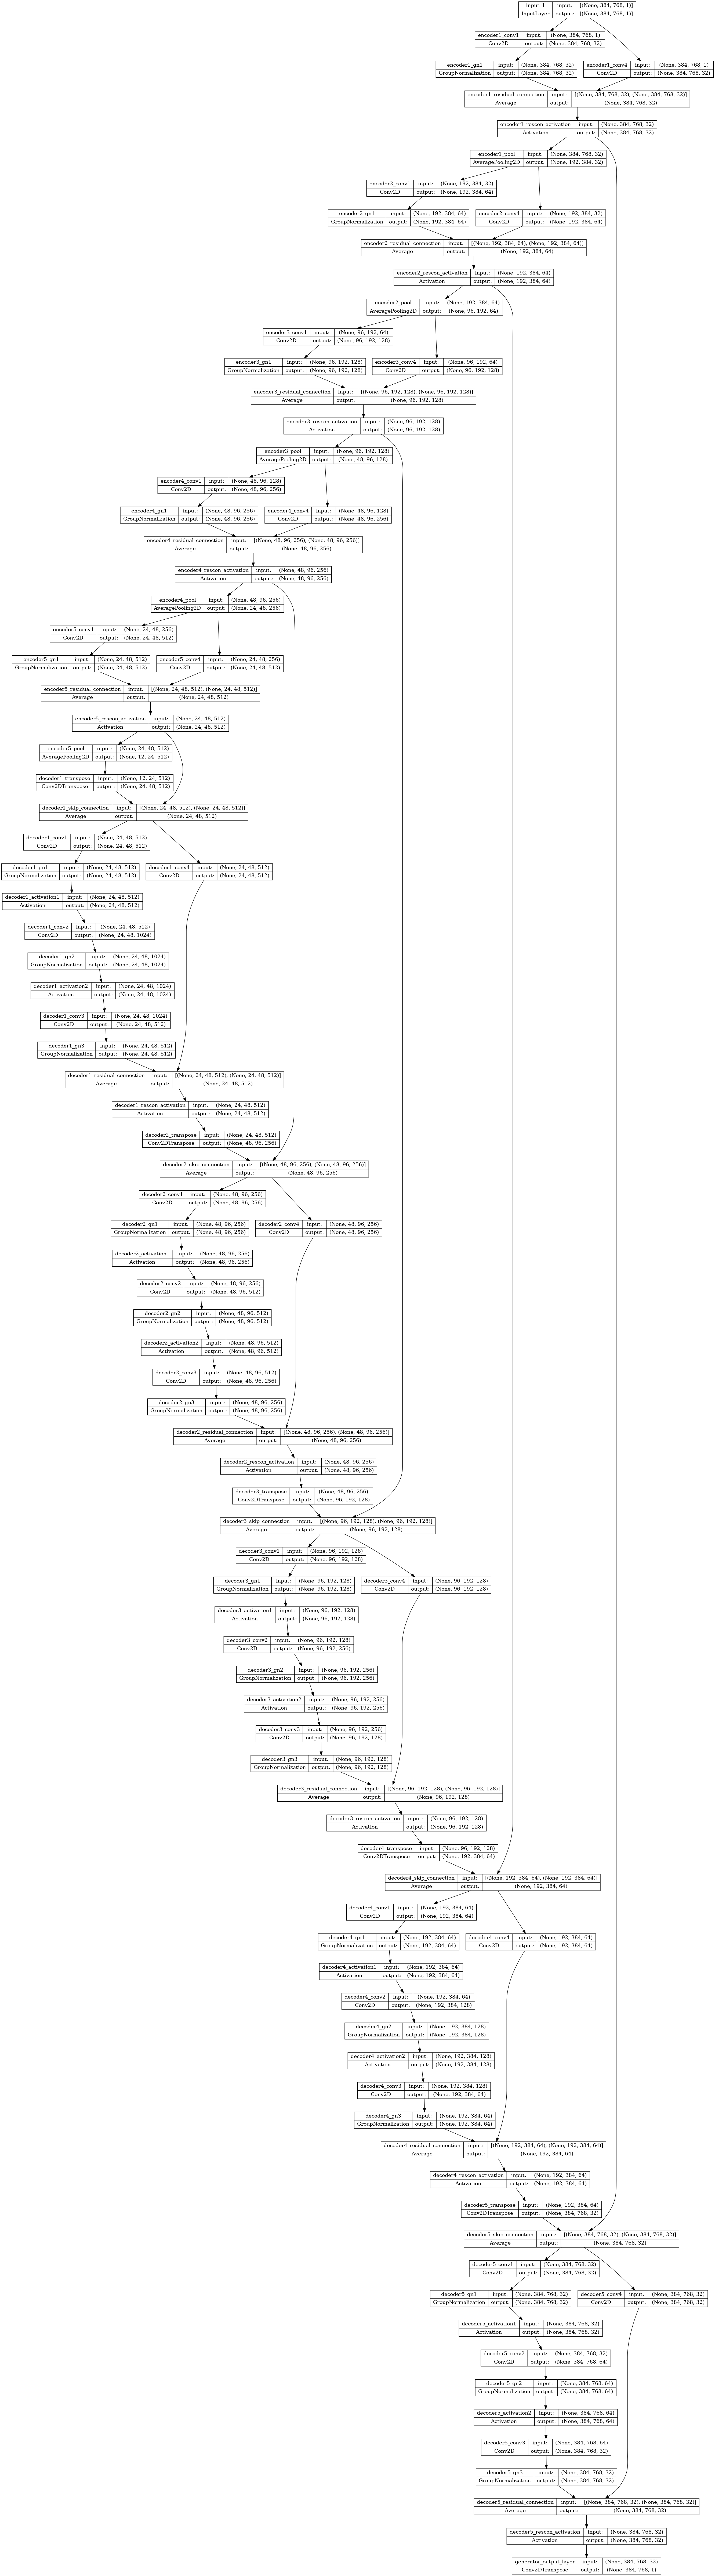

time: 1.23 s (started: 2025-04-28 09:02:00 +00:00)


In [18]:
tf.keras.utils.plot_model(generator, show_shapes = True, show_layer_names=True, to_file='./chart/generator.png')

In [19]:
def discriminator(image_shape, filter, padding, strides, kernel, lossFn, learning_rate, weight_decay, model_weights, weights_path=''):
    ImageInput = layers.Input(shape=image_shape)
    maskInput = layers.Input(shape=image_shape)
    x = layers.multiply([ImageInput, maskInput])
    con1, skip1 = encoder(x, filter, padding=padding, strides=strides, kernel=kernel, activation='swish', name_prefix='disc_encoder1')
    con2, skip2 = encoder(con1, filter*2, padding=padding, strides=strides, kernel=kernel, activation='swish', name_prefix='disc_encoder2')
    con3, skip3 = encoder(con2, filter*4, padding=padding, strides=strides, kernel=kernel, activation='swish', name_prefix='disc_encoder3')
    con4, skip4 = encoder(con3, filter*8, padding=padding, strides=strides, kernel=kernel, activation='swish', name_prefix='disc_encoder4')
    con5, skip5 = encoder(con4, filter*16, padding=padding, strides=strides, kernel=kernel, activation='swish', name_prefix='disc_encoder5')
    x = layers.GlobalAveragePooling2D()(con5)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(1)(x)
    discriminator = models.Model(inputs=[maskInput, ImageInput], outputs=x, name='discriminator')
    if model_weights is not None:
        discriminator.load_weights(weights_path)
    discriminator.compile(loss=lossFn, loss_weights=[1],
                          optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate, weight_decay=weight_decay),)
    discriminator.summary()
    return discriminator

time: 961 µs (started: 2025-04-28 09:02:01 +00:00)


In [20]:
discriminator = discriminator(image_shape=IMAGE_SHAPE, filter=32, padding = 'same', strides=1, kernel=3, 
                              lossFn=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                              learning_rate=ETA, weight_decay=WEIGHT_DECAY,
                              model_weights=None, weights_path="")

Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 384, 768, 1)]        0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 384, 768, 1)]        0         []                            
                                                                                                  
 multiply (Multiply)         (None, 384, 768, 1)          0         ['input_2[0][0]',             
                                                                     'input_3[0][0]']             
                                                                                                  
 disc_encoder1_conv1 (Conv2  (None, 384, 768, 32)         288       ['multiply[0][0]']

In [21]:
# tf.keras.utils.plot_model(discriminator, show_shapes = True, show_layer_names=True, to_file='./chart/discriminator.png')

time: 176 µs (started: 2025-04-28 09:02:01 +00:00)


In [22]:
def GAN(discriminator, generator, learning_rate, weight_decay, lossFn):
    imageInput=layers.Input(shape=IMAGE_SHAPE, name="image_Input")
    maskInput=layers.Input(shape=IMAGE_SHAPE, name="mask_Input")
    
    discriminator.trainable = False
    
    fakeMasks = generator(imageInput)
    discriminatorInput = discriminator([fakeMasks, imageInput])
    
    gan = models.Model(inputs=[maskInput, imageInput],
                       outputs=[discriminatorInput, fakeMasks],
                       name='cgan')
    
    gan.compile(loss=lossFn, loss_weights=[1,100],
                optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate*0.5, weight_decay=weight_decay*0.5))
    gan.summary()
    return gan

time: 1.55 ms (started: 2025-04-28 09:02:01 +00:00)


In [23]:
gan = GAN(discriminator=discriminator, generator=generator,
          learning_rate=ETA, weight_decay=WEIGHT_DECAY, 
          lossFn=[tf.keras.losses.BinaryCrossentropy(from_logits=True),
                 'mae'])

# Notes the loss functions is (log BCE + MAE * 100(lambda))
# Following the isola et al loss functions 

Model: "cgan"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_Input (InputLayer)    [(None, 384, 768, 1)]        0         []                            
                                                                                                  
 generator (Functional)      (None, 384, 768, 1)          2174179   ['image_Input[0][0]']         
                                                          3                                       
                                                                                                  
 mask_Input (InputLayer)     [(None, 384, 768, 1)]        0         []                            
                                                                                                  
 discriminator (Functional)  (None, 1)                    1744609   ['generator[0][0]',        

In [24]:
# tf.keras.utils.plot_model(gan, show_shapes = True, show_layer_names=True, to_file='./chart/gan.png')

time: 171 µs (started: 2025-04-28 09:02:02 +00:00)


In [25]:
def samples(generator, images, realMasks):
    predMasks = generator.predict(images, verbose=0)
    plt.figure(figsize=(12,6))
    for i in range(3):
        plt.subplot(3, 3, i * 3 + 1)
        plt.title('Input Image')
        plt.imshow(images[i], cmap='gray')
        plt.axis('off')

        plt.subplot(3, 3, i * 3 + 2)
        plt.title('Ground Truth')
        plt.imshow(realMasks[i], cmap='gray')
        plt.axis('off')

        plt.subplot(3, 3, i * 3 + 3)
        plt.title('Predicted Mask')
        plt.imshow(predMasks[i], cmap='gray')
        plt.axis('off')
    plt.show()

import gc

tf.keras.backend.clear_session()
gc.collect()

def samples_animated(generator, images, realMasks, output_folder='./animation', filename="sample_pair.png"):
    tf.keras.backend.clear_session()
    gc.collect()
    predMasks = generator.predict(images, verbose=0)
    plt.figure(figsize=(12, 6))

    # Plot input image
    plt.subplot(1, 3, 1)
    plt.title('Input Image')
    plt.imshow(images[1], cmap='gray')
    plt.axis('off')

    # Plot predicted mask
    plt.subplot(1, 3, 2)
    plt.title('Predicted Mask')
    plt.imshow(predMasks[1], cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.title('Ground Truth')
    plt.imshow(realMasks[1], cmap='gray')
    plt.axis('off')

    os.makedirs(output_folder, exist_ok=True)
    output_path = os.path.join(output_folder, filename)
    plt.savefig(output_path, bbox_inches='tight', dpi=300)
    print("save image:",output_path)
    plt.close()

time: 288 ms (started: 2025-04-28 09:02:02 +00:00)


In [26]:
def create_tf_dataset(images, masks, batch_size, is_training=True):
    # Create TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((images, masks))
    
    if is_training:
        # Shuffle with a reasonable buffer size
        dataset = dataset.shuffle(buffer_size=min(1000, len(images)))
    
    # Add batch and prefetch for better performance
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    return dataset

# Create TensorFlow datasets
train_dataset = create_tf_dataset(trainImages, trainMasks, batch_size=BATCH, is_training=True)
valid_dataset = create_tf_dataset(validImages, validMasks, batch_size=BATCH, is_training=False)
test_dataset = create_tf_dataset(testImages, testMasks, batch_size=BATCH, is_training=False)

time: 8.73 s (started: 2025-04-28 09:02:02 +00:00)


In [27]:
del trainImages, validImages, testImages
del trainMasks, validMasks, testMasks

time: 8.83 ms (started: 2025-04-28 09:02:11 +00:00)


In [ ]:
tf.keras.backend.clear_session()
gc.collect()

# Initialize lists to store losses
dlossTagList = []
glossTagList = []
epochs_list = []

for epoch in range(EPOCHS):
    # Reset metrics at start of each epoch
    epoch_d_losses = []
    epoch_g_losses = []
    
    # Iterate through batches in the dataset
    for batch_idx, (realImages, realMasks) in enumerate(train_dataset):
        BATCH = realImages.shape[0]  # Get actual batch size (might be smaller in last batch)
        
        # Real samples
        realTag = tf.ones(shape=(BATCH,))
        
        # Generate fake samples
        fakeMasks = generator.predict([realImages], verbose=0)
        fakeTag = tf.zeros(shape=(BATCH,))
        
        # Combine real and fake samples for discriminator training
        allTags = tf.concat([realTag, fakeTag], axis=0)
        allMasks = tf.concat([realMasks, fakeMasks], axis=0)
        allImages = tf.concat([realImages, realImages], axis=0)
        
        # Train discriminator
        dlossTag = discriminator.train_on_batch([allMasks, allImages], [allTags])
        epoch_d_losses.append(dlossTag)
        
        # Train generator
        glossTag = gan.train_on_batch([realMasks, realImages], [realTag, realMasks])
        epoch_g_losses.append(glossTag)
    
    # Calculate average losses for the epoch
    avg_d_loss = np.mean(epoch_d_losses, axis=0)
    avg_g_loss = np.mean(epoch_g_losses, axis=0)
    
    # Store epoch number and average loss values
    epochs_list.append(epoch)
    dlossTagList.append(avg_d_loss)
    glossTagList.append(avg_g_loss)
    
    # Print progress and generate samples periodically
    if epoch % 40 == 0 or epoch == EPOCHS - 1:
        print(f"Epoch/Epochs: {epoch}/{EPOCHS}")
        print(f"discriminator loss: [tag: {avg_d_loss}], generator loss: [tag: {avg_g_loss}]")
        
        # Generate validation samples using the first batch from validation dataset
        valid_batch = next(iter(valid_dataset))
        valid_images_batch, valid_masks_batch = valid_batch
        samples_animated(generator, valid_images_batch, valid_masks_batch, filename=f'{epoch}_samples.png')

2025-04-28 09:02:14.698450: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-04-28 09:02:27.789878: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f34fc403490 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-04-28 09:02:27.789914: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2025-04-28 09:02:27.795043: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745830947.854581   66272 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch/Epochs: 0/500
discriminator loss: [tag: 0.038441870575155135], generator loss: [tag: [10.56966675  0.02723309  0.10542434]]
save image: ./animation/0_samples.png


## Save Loss List

In [ ]:
# Create a DataFrame with the epoch info
losses_df = pd.DataFrame({'epoch': epochs_list})

# Add discriminator loss
if isinstance(dlossTagList[0], (list, tuple, np.ndarray)) or hasattr(dlossTagList[0], '__iter__') and not isinstance(dlossTagList[0], (str, bytes)):
    for i in range(len(dlossTagList[0])):
        losses_df[f'dloss_{i}'] = [loss[i] for loss in dlossTagList]
else:
    losses_df['dloss'] = dlossTagList

# Add generator loss components
if isinstance(glossTagList[0], (list, tuple, np.ndarray)) or hasattr(glossTagList[0], '__iter__') and not isinstance(glossTagList[0], (str, bytes)):
    # We have multiple generator loss components
    num_g_metrics = len(glossTagList[0])
    # Create a column for each component
    for i in range(num_g_metrics):
        losses_df[f'gloss_{i}'] = [loss[i] for loss in glossTagList]
    losses_df['gloss_total'] = [float(sum(loss)) for loss in glossTagList]
else:
    losses_df['gloss'] = glossTagList

losses_df.to_csv('gan_training_losses.csv', index=False)
print("Losses saved to gan_training_losses.csv")
print(f"CSV columns: {', '.join(losses_df.columns)}")

In [ ]:
df = pd.DataFrame(glossTagList, columns=["loss 1", "loss 2", "loss 3"])
print(f"min mae index-: {df['loss 1'].idxmin()}")
print(f"min mae: {round(np.min(df['loss 1']),4)}")
print(f"last mae: {round(df['loss 1'].iloc[-1],4)}")

plt.figure(figsize=(12, 8))
plt.plot(dlossTagList, label='Discriminator Loss', color='red')
plt.plot(df['loss 1'], label='Generator Loss', color='green')
plt.plot(df['loss 3'], label='L1 Loss (MAE)',  color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('GAN Training Losses')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.legend()
plt.savefig(os.path.join(plot_path, 'first_training_loss_1.png'), dpi=300)
plt.show()

In [ ]:
# First make sure the DataFrame has all metrics correctly labeled
column_names = [
    "discriminator_loss", "discriminator_precision", "discriminator_recall", "discriminator_IoU", "discriminator_dice",
    "generator_adversarial_loss", "generator_mae", "generator_precision", "generator_recall", "generator_IoU", "generator_dice"
]

# Create DataFrame with appropriate column names
df = pd.DataFrame(glossTagList, columns=column_names)

# Create directory for plots if it doesn't exist
os.makedirs(plot_path, exist_ok=True)

# 1. Plot for Loss Values
plt.figure(figsize=(14, 8))
plt.plot(df["discriminator_loss"], label='Discriminator Loss', color='blue', linewidth=2)
plt.plot(df["generator_adversarial_loss"], label='Generator Adversarial Loss', color='orange', linewidth=2)
plt.plot(df["generator_mae"], label='Generator L1 Loss (MAE)', color='green', linewidth=2)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss Value', fontsize=12)
plt.title('GAN Training Losses', fontsize=16)
plt.grid(alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig(os.path.join(plot_path, 'gan_training_losses.png'), dpi=300)
plt.show()

# 2. Plot for Precision and Recall
plt.figure(figsize=(14, 8))
plt.plot(df["discriminator_precision"], label='Discriminator Precision', color='blue', linewidth=2)
plt.plot(df["discriminator_recall"], label='Discriminator Recall', color='cyan', linewidth=2)
plt.plot(df["generator_precision"], label='Generator Precision', color='orange', linewidth=2)
plt.plot(df["generator_recall"], label='Generator Recall', color='red', linewidth=2)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.title('GAN Precision and Recall Metrics', fontsize=16)
plt.grid(alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig(os.path.join(plot_path, 'gan_precision_recall.png'), dpi=300)
plt.show()

# 3. Plot for IoU and Dice Score
plt.figure(figsize=(14, 8))
plt.plot(df["discriminator_IoU"], label='Discriminator IoU', color='blue', linewidth=2)
plt.plot(df["discriminator_dice"], label='Discriminator Dice Score', color='cyan', linewidth=2)
plt.plot(df["generator_IoU"], label='Generator IoU', color='orange', linewidth=2)
plt.plot(df["generator_dice"], label='Generator Dice Score', color='red', linewidth=2)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('GAN IoU and Dice Score Metrics', fontsize=16)
plt.grid(alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig(os.path.join(plot_path, 'gan_iou_dice.png'), dpi=300)
plt.show()

# 4. Combined visualization with subplots
plt.figure(figsize=(20, 15))

# Loss plot
plt.subplot(2, 2, 1)
plt.plot(df["discriminator_loss"], label='Discriminator Loss', color='blue')
plt.plot(df["generator_adversarial_loss"], label='Generator Adv Loss', color='orange')
plt.plot(df["generator_mae"], label='Generator MAE', color='green')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.title('Training Losses')
plt.grid(alpha=0.3)
plt.legend()

# Precision plot
plt.subplot(2, 2, 2)
plt.plot(df["discriminator_precision"], label='Discriminator', color='blue')
plt.plot(df["generator_precision"], label='Generator', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Precision')
plt.grid(alpha=0.3)
plt.legend()

# Recall plot
plt.subplot(2, 2, 3)
plt.plot(df["discriminator_recall"], label='Discriminator', color='blue')
plt.plot(df["generator_recall"], label='Generator', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Recall')
plt.grid(alpha=0.3)
plt.legend()

# IoU and Dice plot
plt.subplot(2, 2, 4)
plt.plot(df["discriminator_IoU"], label='Discriminator IoU', color='blue')
plt.plot(df["generator_IoU"], label='Generator IoU', color='orange')
plt.plot(df["discriminator_dice"], label='Discriminator Dice', color='cyan')
plt.plot(df["generator_dice"], label='Generator Dice', color='red')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('IoU and Dice Score')
plt.grid(alpha=0.3)
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(plot_path, 'gan_all_metrics.png'), dpi=300)
plt.show()

# Print some statistics about key metrics
print(f"Min MAE index: {df['generator_mae'].idxmin()}")
print(f"Min MAE: {round(np.min(df['generator_mae']),4)}")
print(f"Last MAE: {round(df['generator_mae'].iloc[-1],4)}")

print(f"Max Generator IoU: {round(np.max(df['generator_IoU']),4)} at epoch {df['generator_IoU'].idxmax()}")
print(f"Max Generator Dice: {round(np.max(df['generator_dice']),4)} at epoch {df['generator_dice'].idxmax()}")
print(f"Final Generator IoU: {round(df['generator_IoU'].iloc[-1],4)}")
print(f"Final Generator Dice: {round(df['generator_dice'].iloc[-1],4)}")

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(dlossTagList, label='Discriminator Loss', color='blue')
plt.plot(df['loss 5'], label='Generator Loss (log BCE)', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('GAN Training Losses')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.legend()
plt.savefig(os.path.join(plot_path, 'first_training_loss_2.png'), dpi=300)
plt.show()

In [ ]:
# Extract specific losses from glossTagList
epochs = np.arange(len(dlossTagList))

# Discriminator loss
discriminator_loss = [dloss for dloss in dlossTagList]

# Generator losses
generator_total_loss = [gloss[0] for gloss in glossTagList]  # Total generator loss
generator_bce_loss = [gloss[4] for gloss in glossTagList]   # BCE loss
generator_mae_loss = [gloss[2] for gloss in glossTagList]   # MAE loss

# Plotting
plt.figure(figsize=(12, 8))

# Plot Discriminator loss
plt.plot(epochs, discriminator_loss, label="Discriminator Loss", color='red', linewidth=1.5)

# Plot Generator total loss
plt.plot(epochs, generator_total_loss, label="Generator Total Loss (logBCE + MAE * λ)", color='blue', linewidth=1.5)

# Plot Generator BCE loss
plt.plot(epochs, generator_bce_loss, label="Generator BCE Loss (logBCE)", color='green', linestyle='--', linewidth=1.5)

# Plot Generator MAE loss
plt.plot(epochs, generator_mae_loss, label="Generator MAE Loss", color='orange', linestyle='--', linewidth=1.5)
# Customize plot
plt.title("Training Losses for Conditional GAN", fontsize=16)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)

# Save and show plot
plt.tight_layout()
plt.savefig(os.path.join(plot_path, 'first_training_loss_3.png'), dpi=300)
plt.show()

In [ ]:
# Define stable range (e.g., from epoch 500 onward)
stable_start = 500
stable_end = len(epochs)

# Extract stable region losses
stable_dloss = dlossTagList[stable_start:stable_end]
stable_gloss = glossTagList[stable_start:stable_end]

# Generator losses
stable_total_loss = [gloss[0] for gloss in stable_gloss]
stable_bce_loss = [gloss[1] for gloss in stable_gloss]
stable_mae_loss = [gloss[2] for gloss in stable_gloss]

# Calculate mean and standard deviation
dloss_mean, dloss_std = np.mean(stable_dloss), np.std(stable_dloss)
total_mean, total_std = np.mean(stable_total_loss), np.std(stable_total_loss)
bce_mean, bce_std = np.mean(stable_bce_loss), np.std(stable_bce_loss)
mae_mean, mae_std = np.mean(stable_mae_loss), np.std(stable_mae_loss)

# Print results
print(f"Discriminator Loss: Mean = {dloss_mean:.4f}, Std = {dloss_std:.4f}")
print(f"Generator Total Loss: Mean = {total_mean:.4f}, Std = {total_std:.4f}")
print(f"Generator BCE Loss: Mean = {bce_mean:.4f}, Std = {bce_std:.4f}")
print(f"Generator MAE Loss: Mean = {mae_mean:.4f}, Std = {mae_std:.4f}")

# Optional: Add horizontal lines to the plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# Plot losses
plt.plot(epochs, dlossTagList, label="Discriminator Loss", color='red', linewidth=1.5)
plt.plot(epochs, [gloss[1] for gloss in glossTagList], label="Generator BCE Loss", color='green', linestyle='--', linewidth=1.5)
plt.plot(epochs, [gloss[2] for gloss in glossTagList], label="Generator MAE Loss", color='orange', linestyle='--', linewidth=1.5)

# Add horizontal lines for means
plt.axhline(dloss_mean, color='red', linestyle=':', label=f"Discriminator Mean: {dloss_mean:.4f}")
plt.axhline(bce_mean, color='green', linestyle=':', label=f"Generator BCE Mean: {bce_mean:.4f}")
plt.axhline(mae_mean, color='orange', linestyle=':', label=f"Generator MAE Mean: {mae_mean:.4f}")

# Customize plot
plt.title("Losses and Mean Values", fontsize=16)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(plot_path, 'first_training_loss_4.png'), dpi=300)
plt.show()

In [ ]:
generator_saved = f'1024_5block_RMSprop_swish+leakyrelu_CGAN_{EPOCHS}_clahe_generator.h5'
discriminator_saved = f'1024_5block_RMSprop_swish+leakyrelu_CGAN_{EPOCHS}_clahe_discriminator.h5'

generator_path = os.path.join(model_path, generator_saved)
discriminator_path = os.path.join(model_path, discriminator_saved)

generator.save_weights(generator_path)
discriminator.save_weights(discriminator_path)

# - Now we will train the generator again with a number of layers frozen in order to maintain the capacity that the generator has gained.

In [ ]:
weight_path = generator_path

generator2 = generator(input=layers.Input(shape=IMAGE_SHAPE), filter=32, padding='same', kernel=3, strides=1, 
                             model_weights=True, weights_path=weight_path)

for layer in generator2.layers[:20]:
    layer.trainable = False
    
optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-5, weight_decay=1e-7)
generator2.compile(loss=bce_dice_loss,
                         optimizer=optimizer, 
                         metrics=[tf.keras.metrics.Precision(name = 'precision'),
                                  tf.keras.metrics.Recall(name = 'recall'), 
                                  tf.keras.metrics.BinaryIoU(name = 'IoU'),
                                  dice_score,
                                  tf.keras.metrics.BinaryCrossentropy(name='logBCE', from_logits=True),
                                  tf.keras.metrics.MeanAbsoluteError(name='MAE')])

# Evaluate the generator model

In [ ]:
generator2.evaluate(validImages, validMasks, batch_size=BATCH)

In [ ]:
generator2.evaluate(testImages, testMasks, batch_size=BATCH)

In [ ]:
def draw(images, masks, y_pred):
    plt.figure(figsize = (12, 24))
    index = -1
    n = np.random.randint(y_pred.shape[0])
    for i in range(120):
        plt.subplot(20, 6, (i + 1))
        if index == -1:
            plt.imshow(images[n], cmap = 'gray')
            plt.title('Image')
            plt.axis('off')
            index = 0
        elif index == 0:
            plt.imshow(images[n], cmap = 'gray')
            plt.imshow(masks[n], alpha = 0.6, cmap = 'gray')
            plt.title('Original Mask')
            plt.axis('off')
            index = 1
        elif index == 1:
            plt.imshow(images[n], cmap = 'gray')
            plt.imshow(np.reshape(y_pred[n], IMAGE_SHAPE[:2]), alpha = 0.6, cmap = 'gray')
            plt.title('Predict Mask')
            plt.axis('off')
            index = -1
            n = np.random.randint(y_pred.shape[0])
    plt.legend()

In [ ]:
masks_pred = generator2.predict(validImages, verbose=0, batch_size=BATCH)
masks_pred = (masks_pred >= 0.5).astype('int')
masks_pred.shape
draw(validImages, validMasks, masks_pred)

# Re-training of the generator according to the pixel2pixel methodology

In [ ]:
def create_tf_dataset(images, masks, batch_size, is_training=True):
    # Convert numpy arrays to tensors
    images_tensor = tf.convert_to_tensor(images, dtype=tf.float32)
    masks_tensor = tf.convert_to_tensor(masks, dtype=tf.float32)
    
    # Create TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((images_tensor, masks_tensor))
    
    if is_training:
        # Only shuffle for training dataset
        dataset = dataset.cache().shuffle(buffer_size=len(images))
    
    # Batch and prefetch
    dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset

# Create TensorFlow datasets
train_dataset = create_tf_dataset(trainImages, trainMasks, batch_size=2, is_training=True)
valid_dataset = create_tf_dataset(validImages, validMasks, batch_size=2, is_training=False)
test_dataset = create_tf_dataset(testImages, testMasks, batch_size=2, is_training=False)

In [ ]:
train_samples = len(trainImages)
steps_per_epoch = train_samples // 2

del trainImages
del trainMasks

In [ ]:
import gc

tf.keras.backend.clear_session()
gc.collect()

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=1e-4,
    patience=10,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1,           # Reduce the learning rate by a factor of 0.2
    patience=3,           # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1,
    mode='min',
    min_delta=1e-4,       # minimum changed in monitor metrics
)

history = generator2.fit(train_dataset, 
                         epochs=100,
                         steps_per_epoch=steps_per_epoch,
                         validation_data=valid_dataset, 
                         verbose=2, 
                         callbacks=[early_stopping, reduce_lr])

# The results obtained

In [ ]:
metrics = ['loss', 'precision', 'recall', 'IoU', 'dice_score', 'logBCE', 'MAE']
plt.figure(figsize = (15, 24))
for i in range(7):
    plt.subplot(4, 2, (i + 1))
    plt.plot(history.history['{}'.format(metrics[i])], label = '{}'.format(metrics[i]))
    plt.plot(history.history['val_{}'.format(metrics[i])], label = 'val_{}'.format(metrics[i]))
    plt.title('{}'.format(metrics[i]))
    plt.grid(alpha=0.3)
    plt.legend()
plt.savefig(os.path.join(plot_path, 'secondtrain_history_chart_1.png'), dpi=300)

In [ ]:
metrics = ['precision', 'recall', 'IoU', 'dice_score', 'logBCE', 'MAE']
plt.figure(figsize = (15, 18))
for i in range(6):
    plt.subplot(3, 2, (i + 1))
    plt.plot(history.history['{}'.format(metrics[i])], label = '{}'.format(metrics[i]))
    plt.plot(history.history['val_{}'.format(metrics[i])], label = 'val_{}'.format(metrics[i]))
    plt.title('{}'.format(metrics[i]))
    plt.grid(alpha=0.3)
    plt.legend()
plt.savefig(os.path.join(plot_path, 'secondtrain_history_chart_2.png'), dpi=300)

In [ ]:
generator2.evaluate(valid_dataset)

In [ ]:
generator2.evaluate(test_dataset)

In [ ]:
generator_path2 = os.path.join(model_path, 'final', f'final_{generator_saved}')
generator2.save(generator_path2)

In [ ]:
generator3 = tf.keras.models.load_model("/notebooks/models/final/final_1024_5block_RMSprop_swish+leakyrelu_CGAN_2000_clahe_generator.h5",
                                        custom_objects={'bce_dice_loss':bce_dice_loss,
                                                        'dice_score': dice_score})

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd # For easier manipulation

# Assuming generator3, validImages, validMasks are already defined and used for prediction
predIdxs = generator3.predict(validImages, batch_size=8)
predIdxs = (predIdxs >= 0.5).astype('int')

validMasks_flat = validMasks.flatten()
predIdxs_flat = predIdxs.flatten()

print("validMasks shape:", validMasks_flat.shape)
print("predIdxs shape:", predIdxs_flat.shape)

class_names = ["Positive", "Negative"]
class_mapping = {label: i for i, label in enumerate(class_names)} # {'Positive': 0, 'Negative': 1}

print(classification_report(
    validMasks_flat, predIdxs_flat,
    target_names=class_names
))

# Generate the confusion matrix without explicit labels
conf_mat_initial = confusion_matrix(validMasks_flat, predIdxs_flat)

# Create a DataFrame for easier reordering based on class names
conf_df = pd.DataFrame(conf_mat_initial, index=np.unique(validMasks_flat), columns=np.unique(predIdxs_flat))

# Create the reordered matrix based on our desired class order
reordered_conf_mat = np.array([
    conf_df.loc[class_mapping['Positive'], class_mapping['Positive']], # TP
    conf_df.loc[class_mapping['Positive'], class_mapping['Negative']], # FP
    conf_df.loc[class_mapping['Negative'], class_mapping['Positive']], # FN
    conf_df.loc[class_mapping['Negative'], class_mapping['Negative']]  # TN
]).reshape(2, 2)

plt.figure(figsize=(8, 6))
sns.heatmap(reordered_conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
plt.savefig('/notebooks/chart/secondtrain_confusion_matrix.png')

In [ ]:
masksPred = generator3.predict(validImages, verbose=0, batch_size=8)
masksPred = (masksPred >= 0.5).astype('int')
print(masksPred.shape)
draw(validImages, validMasks, masksPred)

In [ ]:
masksPred = generator3.predict(testImages, verbose=0, batch_size=8)
masksPred = (masksPred >= 0.5).astype('int')
print(masks_pred.shape)
draw(testImages, testMasks, masksPred)

In [ ]:
masksPred = generator3.predict(trainImages, verbose=0, batch_size=8)
masksPred = (masksPred >= 0.5).astype('int')
print(masks_pred.shape)
draw(trainImages, trainMasks, masksPred)

In [ ]:
import zipfile,os
folder_to_zip = os.path.join(plot_path,'chart')
zip_file_name =  os.path.splitext(generator_saved)[0].replace("_generator", "") + '.zip'
zip_file_name = os.path.join(plot_path, zip_file_name)
with zipfile.ZipFile(zip_file_name, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for foldername, subfolders, filenames in os.walk(folder_to_zip):
        for filename in filenames:
            file_path = os.path.join(foldername, filename)
            arcname = os.path.relpath(file_path, folder_to_zip)
            zipf.write(file_path, arcname)
zipf.close()

print(f"{zip_file_name} success zipping...")